In [1]:
from tqdm import tqdm
import json
import os
import torch
from PIL import Image
from torchvision.transforms import ToTensor, Resize, Compose, Normalize
from torch.utils.data import Dataset
from transformers import ViTModel, ViTConfig
import torch.nn as nn
from torchvision.transforms import Compose, ToTensor, Normalize
from torch.utils.data import DataLoader
import torch.optim as optim
import random
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
import numpy as np

In [2]:
class PoseEstimationDataset(Dataset):
    def __init__(self, json_path, image_dir, transform=None, target_size=(224, 224)):
        self.image_dir = image_dir
        self.transform = transform
        self.target_size = target_size

        with open(json_path, 'r') as file:
            self.data = json.load(file)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        max_people = 13
        num_keypoints = 16  # Assuming 16 keypoints per person

        image_path = os.path.join(self.image_dir, item['image_filename'])
        image = Image.open(image_path)
        orig_image = image.copy()  # Make a copy of the original image
        orig_width, orig_height = image.size

        if self.transform:
            image = self.transform(image)

        keypoints_tensor = torch.zeros((max_people, num_keypoints, 2))

        for i, (joint_name, joint_data) in enumerate(item['ground_truth'].items()):
            for j, joint in enumerate(joint_data):
                if j >= max_people:
                    break  # Skip extra people
                x, y = joint[:2]  # Only take x and y, ignoring visibility
                keypoints_tensor[j, i, 0] = x / orig_width
                keypoints_tensor[j, i, 1] = y / orig_height

        # Denormalize the keypoints
        denormalized_keypoints = keypoints_tensor.clone()
        for person in range(max_people):
            for kpt in range(num_keypoints):
                denormalized_keypoints[person, kpt, 0] *= orig_width
                denormalized_keypoints[person, kpt, 1] *= orig_height

        return orig_image, image, keypoints_tensor, denormalized_keypoints, item['image_filename'], orig_width, orig_height    



In [3]:
json_path = '/home/ps332/myViT/data/mpii_data.json'
image_dir = '/home/ps332/myViT/data/mpii_data/images/images'
# Define any transforms you want to apply to your images
# For example, normalization as used in your model
transforms = Compose([
    Resize((224, 224)),  # Resize the image
    ToTensor(),  # Convert the image to a PyTorch tensor
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the tensor
])

# Instantiate the dataset
dataset = PoseEstimationDataset(
    json_path=json_path,
    image_dir=image_dir,
    transform=None
)

# Now when you iterate over the dataset, you can print the denormalized keypoints
for i in range(5):  # Adjust the range as needed
    orig_image,image, keypoints, denormalized_keypoints, image_filename, orig_height, orig_width = dataset[i]
    print(f"Image: {image_filename}")
    print("Denormalized keypoints:")
    print(denormalized_keypoints)

Image: 015601864.jpg
Denormalized keypoints:
tensor([[[ 620.0000,  394.0000],
         [ 616.0000,  269.0000],
         [ 573.0000,  185.0000],
         [ 647.0000,  188.0000],
         [ 661.0000,  221.0000],
         [ 656.0000,  231.0000],
         [ 610.0000,  187.0000],
         [ 647.0000,  176.0000],
         [ 637.0000,  189.8750],
         [ 696.0000,  108.1875],
         [ 606.0000,  217.0000],
         [ 553.0000,  161.0000],
         [ 601.0000,  167.0000],
         [ 692.0000,  185.0000],
         [ 693.0000,  240.0000],
         [ 688.0000,  313.0000]],

        [[ 895.0000,  293.0000],
         [ 910.0000,  279.0000],
         [ 945.0000,  223.0000],
         [1012.0000,  218.0000],
         [ 961.0000,  315.0000],
         [ 960.0000,  403.0000],
         [ 979.0000,  221.0000],
         [ 906.0000,  190.0000],
         [ 912.5000,  190.6250],
         [ 830.5000,  182.3750],
         [ 871.0000,  304.0000],
         [ 883.0000,  229.0000],
         [ 888.0000,  174.000

In [4]:
num_keypoints = 16
class PoseEstimationModule(nn.Module):
    def __init__(self, num_keypoints, max_people=13):
        super().__init__()
        config = ViTConfig.from_pretrained('google/vit-base-patch16-224')
        self.backbone = ViTModel.from_pretrained('google/vit-base-patch16-224', config=config)
        hidden_size = self.backbone.config.hidden_size

        self.max_people = max_people

        # Head for keypoint coordinates
        self.keypoint_regression_head = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.BatchNorm1d(hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size // 2, 2 * num_keypoints * max_people),
            nn.BatchNorm1d(2 * num_keypoints * max_people)
        )

        
    def forward(self, x):
        outputs = self.backbone(x)
        x = outputs.last_hidden_state[:, 0, :]
        x = self.keypoint_regression_head(x)
        x = x.view(x.size(0), self.max_people, num_keypoints, 2)  # Reshape to [batch_size, max_people, num_keypoints, 2]
        # Apply sigmoid to the output to constrain the values between 0 and 1
        x = torch.sigmoid(x)


        return x


Image: 015601864.jpg, Size: (1280, 720)
Keypoints: [[620.0, 394.0, 1.0], [895.0, 293.0, 1.0], [616.0, 269.0, 1.0], [910.0, 279.0, 1.0], [573.0, 185.0, 1.0], [945.0, 223.0, 0.0], [647.0, 188.0, 0.0], [1012.0, 218.0, 1.0], [661.0, 221.0, 1.0], [961.0, 315.0, 1.0], [656.0, 231.0, 1.0], [960.0, 403.0, 1.0], [610.0, 187.0, 0.0], [979.0, 221.0, 0.0], [647.0, 176.0, 1.0], [906.0, 190.0, 0.0], [637.0, 189.875, 1.0], [912.5, 190.625, 1.0], [696.0, 108.1875, 1.0], [830.5, 182.375, 1.0], [606.0, 217.0, 1.0], [871.0, 304.0, 1.0], [553.0, 161.0, 1.0], [883.0, 229.0, 1.0], [601.0, 167.0, 1.0], [888.0, 174.0, 0.0], [692.0, 185.0, 1.0], [924.0, 206.0, 1.0], [693.0, 240.0, 1.0], [1013.0, 203.0, 1.0], [688.0, 313.0, 1.0], [955.0, 263.0, 1.0]]


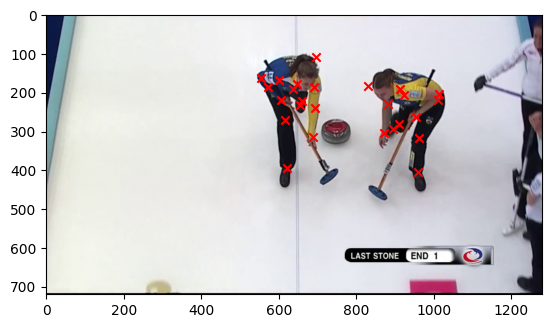

Image: 015599452.jpg, Size: (1280, 720)
Keypoints: [[228.0, 537.0, 1.0], [74.0, 536.0, 1.0], [151.0, 537.0, 1.0], [129.0, 251.0, 1.0], [123.0, 218.0, 1.0], [89.0, 31.0, 1.0], [220.0, 373.0, 0.0], [297.0, 456.0, 1.0], [232.0, 251.0, 1.0], [26.0, 251.0, 1.0], [26.0, 423.0, 1.0]]


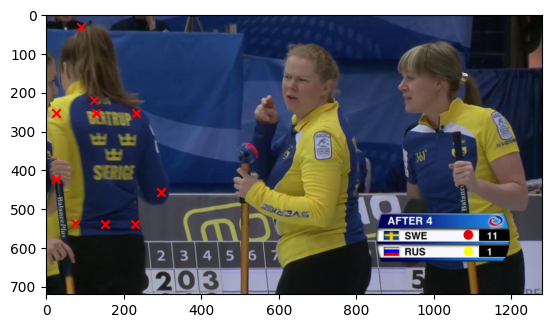

Image: 060111501.jpg, Size: (1280, 720)
Keypoints: [[980.0, 322.0, 1.0], [896.0, 318.0, 0.0], [865.0, 248.0, 1.0], [943.0, 226.0, 1.0], [948.0, 290.0, 1.0], [881.0, 349.0, 1.0], [904.0, 237.0, 1.0], [858.0, 135.0, 1.0], [871.0, 180.375, 1.0], [836.0, 58.5625, 1.0], [772.0, 294.0, 1.0], [754.0, 247.0, 1.0], [792.0, 147.0, 1.0], [923.0, 123.0, 1.0], [995.0, 163.0, 0.0], [961.0, 223.0, 0.0]]


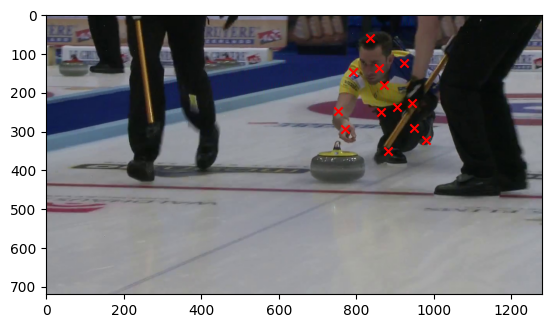

Image: 002058449.jpg, Size: (1280, 720)
Keypoints: [[918.0, 456.0, 1.0], [659.0, 518.0, 1.0], [713.0, 413.0, 1.0], [979.0, 288.0, 1.0], [1222.0, 453.0, 1.0], [974.0, 399.0, 0.0], [846.0, 351.0, 1.0], [738.0, 259.0, 1.0], [795.5, 315.0, 1.0], [597.5, 122.125, 1.0], [441.0, 490.0, 1.0], [446.0, 434.0, 1.0], [599.0, 270.0, 1.0], [877.0, 247.0, 1.0], [1112.0, 384.0, 1.0], [1012.0, 489.0, 1.0]]


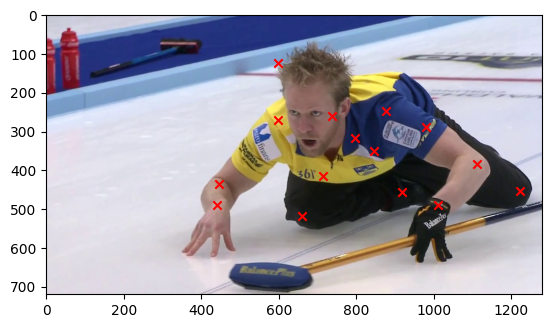

Image: 030424224.jpg, Size: (854, 480)
Keypoints: [[324.0, 406.0, 1.0], [476.0, 407.0, 1.0], [322.0, 291.0, 1.0], [476.0, 295.0, 1.0], [293.0, 262.0, 1.0], [510.0, 264.0, 1.0], [355.0, 267.0, 1.0], [564.0, 265.0, 1.0], [401.0, 292.0, 1.0], [581.0, 303.0, 1.0], [394.0, 404.0, 1.0], [575.0, 412.0, 1.0], [324.0, 265.0, 1.0], [537.0, 265.0, 1.0], [334.0, 170.0, 1.0], [535.0, 175.0, 1.0], [338.75, 157.25, 1.0], [535.0, 172.75, 1.0], [360.25, 97.8125, 1.0], [532.0, 104.1875, 1.0], [363.0, 167.0, 1.0], [508.0, 183.0, 1.0], [319.0, 205.0, 1.0], [492.0, 238.0, 1.0], [298.0, 168.0, 1.0], [493.0, 173.0, 1.0], [369.0, 172.0, 1.0], [577.0, 176.0, 1.0], [390.0, 221.0, 1.0], [591.0, 235.0, 1.0], [398.0, 179.0, 1.0], [556.0, 190.0, 1.0]]


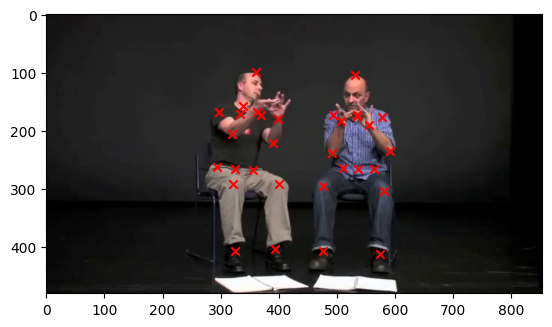

Image: 052475643.jpg, Size: (854, 480)
Keypoints: [[317.0, 412.0, 1.0], [478.0, 407.0, 1.0], [318.0, 299.0, 1.0], [473.0, 306.0, 1.0], [290.0, 274.0, 1.0], [495.0, 270.0, 1.0], [353.0, 275.0, 1.0], [567.0, 273.0, 1.0], [403.0, 299.0, 1.0], [580.0, 308.0, 1.0], [394.0, 409.0, 1.0], [584.0, 405.0, 1.0], [322.0, 275.0, 1.0], [531.0, 272.0, 1.0], [327.0, 172.0, 1.0], [528.0, 178.0, 1.0], [330.0, 162.125, 1.0], [527.5, 173.125, 1.0], [347.0, 105.875, 1.0], [518.5, 103.875, 1.0], [296.0, 135.0, 1.0], [494.0, 186.0, 1.0], [281.0, 208.0, 1.0], [468.0, 239.0, 1.0], [296.0, 167.0, 1.0], [479.0, 182.0, 1.0], [358.0, 177.0, 1.0], [577.0, 173.0, 1.0], [387.0, 236.0, 1.0], [587.0, 230.0, 1.0], [392.0, 167.0, 1.0], [553.0, 180.0, 1.0]]


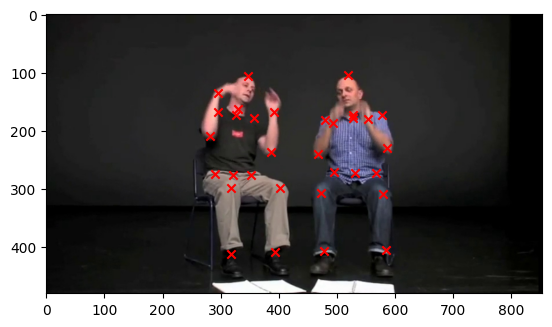

Image: 029122914.jpg, Size: (720, 480)
Keypoints: [[301.0, 473.0, 1.0], [302.0, 346.0, 1.0], [362.0, 345.0, 1.0], [367.0, 470.0, 1.0], [332.0, 346.0, 1.0], [325.0, 217.0, 1.0], [326.25, 196.125, 1.0], [330.75, 122.8125, 1.0], [275.0, 299.0, 1.0], [262.0, 300.0, 1.0], [278.0, 220.0, 1.0], [371.0, 213.0, 1.0], [396.0, 309.0, 1.0], [393.0, 290.0, 1.0]]


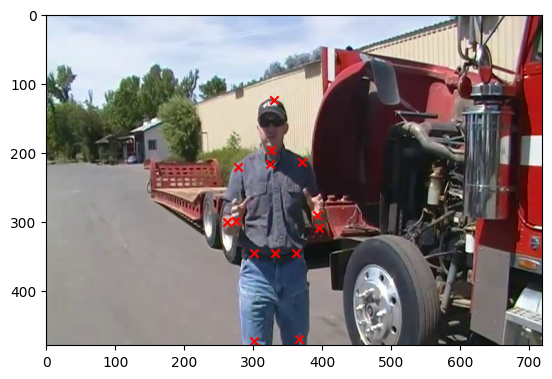

Image: 061185289.jpg, Size: (720, 480)
Keypoints: [[533.0, 322.0, 0.0], [515.0, 277.25, 1.0], [464.0, 148.875, 1.0], [353.0, 172.0, 1.0], [426.0, 239.0, 1.0], [513.0, 288.0, 0.0], [552.0, 355.0, 1.0]]


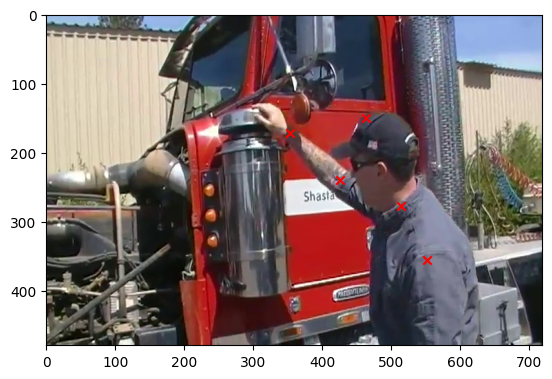

Image: 013949386.jpg, Size: (720, 480)
Keypoints: [[110.0, 385.0, 1.0], [208.0, 355.0, 1.0], [159.0, 370.0, 1.0], [189.0, 228.0, 1.0], [191.125, 227.125, 1.0], [327.0, 168.875, 1.0], [367.0, 363.0, 1.0], [254.0, 429.0, 1.0], [166.0, 303.0, 1.0], [212.0, 153.0, 1.0], [319.0, 123.0, 1.0], [376.0, 39.0, 1.0]]


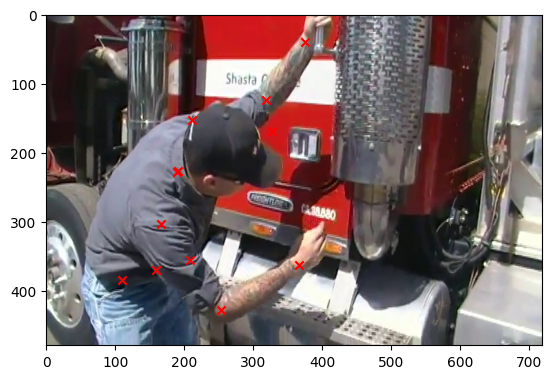

Image: 029214465.jpg, Size: (720, 480)
Keypoints: [[208.0, 331.0, 1.0], [159.0, 313.0, 0.0], [184.0, 322.0, 0.0], [198.0, 105.0, 0.0], [216.625, 87.6875, 1.0], [295.5, 14.328125, 1.0], [322.0, 385.0, 1.0], [254.0, 278.0, 1.0], [222.0, 118.0, 1.0], [174.0, 92.0, 0.0], [181.0, 226.0, 0.0], [197.0, 364.0, 0.0]]


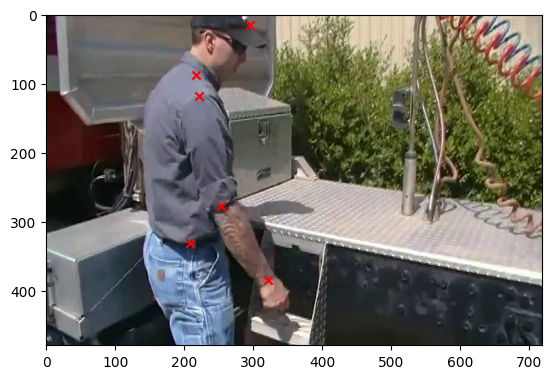

Keypoint [581.0, 480.0, 1.0] is out of bounds in image 036636184.jpg
Image: 036636184.jpg, Size: (720, 480)
Keypoints: [[525.0, 478.0, 1.0], [529.0, 369.0, 1.0], [517.0, 220.0, 1.0], [570.0, 204.0, 1.0], [574.0, 371.0, 1.0], [544.0, 212.0, 1.0], [488.0, 76.0, 1.0], [479.0, 71.5625, 1.0], [393.0, 28.453125, 1.0], [416.0, 251.0, 1.0], [469.0, 201.0, 1.0], [459.0, 104.0, 1.0], [516.0, 48.0, 1.0], [588.0, 132.0, 1.0], [587.0, 242.0, 1.0]]


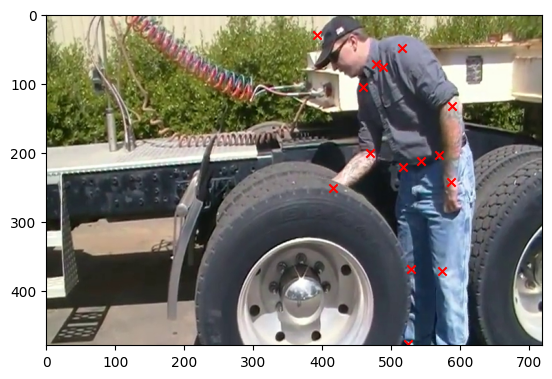

Keypoint [610.0, 480.0, 1.0] is out of bounds in image 045606998.jpg
Image: 045606998.jpg, Size: (720, 480)
Keypoints: [[555.0, 370.0, 0.0], [568.0, 298.0, 0.0], [559.0, 255.0, 0.0], [645.0, 140.0, 1.0], [600.0, 343.0, 1.0], [602.0, 198.0, 0.0], [515.0, 179.0, 0.0], [508.25, 181.375, 1.0], [395.75, 221.625, 1.0], [495.0, 361.0, 1.0], [470.0, 285.0, 1.0], [464.0, 170.0, 0.0], [566.0, 187.0, 1.0], [671.0, 230.0, 1.0], [591.0, 316.0, 1.0]]


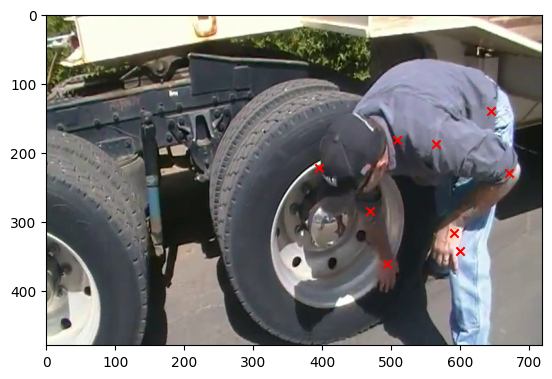

Image: 051423444.jpg, Size: (1280, 720)
Keypoints: [[1033.0, 649.0, 1.0], [1072.0, 474.0, 1.0], [973.0, 496.0, 1.0], [961.0, 650.0, 1.0], [1023.0, 485.0, 1.0], [1031.0, 295.0, 1.0], [1027.0, 281.5, 1.0], [997.0, 181.375, 1.0], [988.0, 294.0, 0.0], [1018.0, 317.0, 0.0], [1070.0, 290.0, 1.0], [991.0, 300.0, 1.0], [912.0, 345.0, 1.0], [842.0, 330.0, 1.0]]


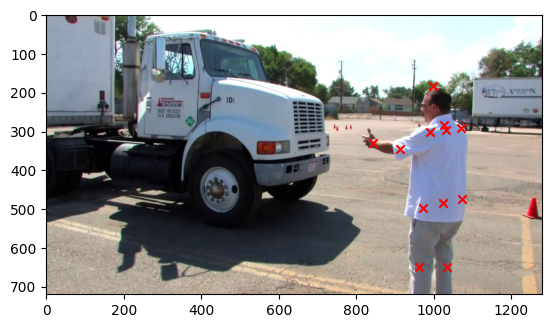

Image: 059241457.jpg, Size: (1280, 720)
Keypoints: [[548.0, 675.0, 1.0], [563.0, 514.0, 1.0], [626.0, 510.0, 1.0], [602.0, 664.0, 1.0], [595.0, 512.0, 1.0], [611.0, 308.0, 1.0], [615.0, 299.25, 1.0], [658.0, 211.625, 1.0], [522.0, 488.0, 1.0], [522.0, 404.0, 1.0], [571.0, 304.0, 1.0], [651.0, 312.0, 1.0], [687.0, 324.0, 1.0], [716.0, 299.0, 1.0]]


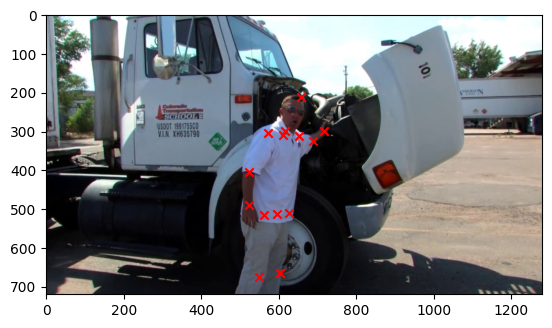

Image: 004645041.jpg, Size: (1280, 720)
Keypoints: [[804.0, 659.0, 1.0], [786.0, 498.0, 1.0], [868.0, 509.0, 1.0], [860.0, 693.0, 1.0], [827.0, 504.0, 1.0], [840.0, 314.0, 1.0], [839.0, 309.0, 1.0], [816.0, 203.125, 1.0], [698.0, 264.0, 1.0], [740.0, 297.0, 1.0], [790.0, 300.0, 1.0], [889.0, 328.0, 1.0], [915.0, 452.0, 1.0], [906.0, 553.0, 1.0]]


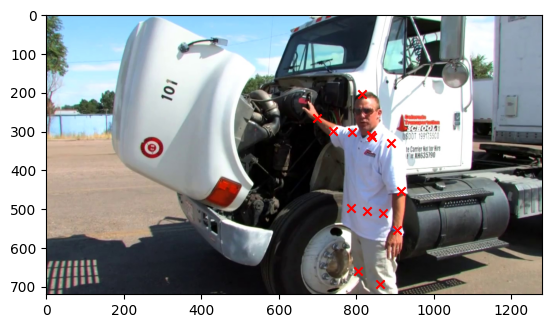

In [6]:
#THESE ARE ALL CORRECT VISUALLY FOR THE GROUND TRUTH DATA

import json
import os
from PIL import Image
import matplotlib.pyplot as plt

def plot_keypoints(image, keypoints):
    plt.imshow(image)
    for point in keypoints:
        if len(point) == 3:  # if the keypoints include visibility flags
            x, y, visible = point
            if visible:
                plt.scatter(x, y, c='red', marker='x')
        else:  # if keypoints are just x, y coordinates
            x, y = point
            plt.scatter(x, y, c='red', marker='x')
    plt.show()

def check_keypoints(json_path, image_dir):
    with open(json_path, 'r') as file:
        data = json.load(file)

    # Check each image and its keypoints
    for item in data[:15]:
        image_path = os.path.join(image_dir, item['image_filename'])
        
        
        if not os.path.exists(image_path):
            print(f"Image {item['image_filename']} not found.")
            continue

        image = Image.open(image_path)
        orig_width, orig_height = image.size
        keypoints = []

        for joint_data in item['ground_truth'].values():
            for point in joint_data:
                # Add a check for keypoints within the image dimensions
                if not (0 <= point[0] < orig_width and 0 <= point[1] < orig_height):
                    print(f"Keypoint {point} is out of bounds in image {item['image_filename']}")
                    continue
                keypoints.append(point)

        print(f"Image: {item['image_filename']}, Size: ({orig_width}, {orig_height})")
        print(f"Keypoints: {keypoints}")

        # Optional: visualize the keypoints
        plot_keypoints(image, keypoints)

check_keypoints(json_path, image_dir)


In [ ]:
import json
import os
from PIL import Image
import matplotlib.pyplot as plt

json_path = '/home/ps332/myViT/data/mpii_data.json'
image_dir = '/home/ps332/myViT/data/mpii_data/images/images'

def plot_keypoints(image, keypoints):
    plt.imshow(image)
    for i, point in enumerate(keypoints):
        if len(point) == 3:  # if the keypoints include visibility flags
            x, y, visible = point
            if visible:
                plt.scatter(x, y, c='red', marker='x')
        else:  # if keypoints are just x, y coordinates
            x, y = point
            plt.scatter(x, y, c='red', marker='x')
        
        # Draw lines between keypoints
        if i > 0 and i < len(keypoints) - 1:
            prev_x, prev_y = keypoints[i - 1][:2]
            next_x, next_y = keypoints[i + 1][:2]
            
            # Calculate the Euclidean distance between the current and next keypoints
            distance = ((next_x - x) ** 2 + (next_y - y) ** 2) ** 0.5
            
            # Only draw the line if the distance is small (you can adjust this threshold)
            if distance < 50:  # You can adjust this threshold as needed
                plt.plot([prev_x, x, next_x], [prev_y, y, next_y], c='blue')
    
    # Connect the last and first keypoints to form a closed shape
    if len(keypoints) > 1:
        first_x, first_y = keypoints[0][:2]
        last_x, last_y = keypoints[-1][:2]
        plt.plot([last_x, first_x], [last_y, first_y], c='blue')

    plt.show()

def check_keypoints(json_path, image_dir):
    with open(json_path, 'r') as file:
        data = json.load(file)

    # Check each image and its keypoints
    for item in data:
        image_path = os.path.join(image_dir, item['image_filename'])
        
        if not os.path.exists(image_path):
            print(f"Image {item['image_filename']} not found.")
            continue

        image = Image.open(image_path)
        orig_width, orig_height = image.size
        keypoints = []

        for joint_data in item['ground_truth'].values():
            for point in joint_data:
                # Add a check for keypoints within the image dimensions
                if not (0 <= point[0] < orig_width and 0 <= point[1] < orig_height):
                    print(f"Keypoint {point} is out of bounds in image {item['image_filename']}")
                    continue
                keypoints.append(point)

        # Optional: visualize the keypoints with lines (non-overlapping)
        plot_keypoints(image, keypoints)

check_keypoints(json_path, image_dir)


In [ ]:
from PIL import Image, ImageDraw

def plot_keypoints(orig_images, denormalized_keypoints):
    # Assuming batch_size is the first dimension
    batch_size, num_keypoints, _ = denormalized_keypoints.shape
    
    # Define marker size and label offset for keypoints
    marker_size = 5
    label_offset = (5, 5)
    
    # Iterate over each image in the batch
    for i in range(batch_size):
        # Convert the original image (PIL Image) to a NumPy array
        orig_image_np = np.array(orig_images[i])
        
        # Create a copy of the image to draw keypoints on
        image_with_keypoints = Image.fromarray(orig_image_np)
        draw = ImageDraw.Draw(image_with_keypoints)
        
        # Extract keypoints for the current image
        kpts = denormalized_keypoints[i].cpu().numpy()
        print(kpts)
        
        # Plot each keypoint on the image
        for kpt in range(num_keypoints):
            x, y = kpts[kpt]
            x = int(x)  # Convert to integer for drawing
            y = int(y)  # Convert to integer for drawing
            
            # Draw a filled circle as the keypoint marker
            draw.ellipse([x - marker_size, y - marker_size, x + marker_size, y + marker_size], fill='red')
            
            # Add a text label near the keypoint for better visibility
            label_position = (x + label_offset[0], y + label_offset[1])
            draw.text(label_position, str(kpt), fill='red')
        
        # Display the image with keypoints
        image_with_keypoints.show()

In [ ]:
from torchvision.transforms.functional import to_tensor

def my_collate(batch):
    batch = list(filter(lambda x: x is not None, batch))  # Filter out all the Nones
    if not batch:
        return torch.utils.data.dataloader.default_collate([None])
    
    # Unzip the batch
    orig_images, tensors, keypoints, denorm_keypoints, filenames, widths, heights = zip(*batch)

    # Convert PIL images to tensors if not already done
    tensors = torch.stack(tensors, 0)  # 'tensors' are already tensors
    keypoints = torch.stack(keypoints, 0)
    denorm_keypoints = torch.stack(denorm_keypoints, 0)
    widths = torch.tensor(widths)
    heights = torch.tensor(heights)

    # 'filenames' is a tuple of strings, we don't stack it, just convert it to a list
    filenames = list(filenames)

    # Combine everything into a batch
    # Note that orig_images are not converted to tensors and should be handled separately
    batch = orig_images, tensors, keypoints, denorm_keypoints, filenames, widths, heights
    return batch



In [ ]:
num_epochs = 10
random_seed = 42
torch.manual_seed(random_seed)
random.seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
   
# Device selection (CUDA GPU if available, otherwise CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

json_path = '/home/ps332/myViT/data/mpii_data.json'
image_dir = '/home/ps332/myViT/data/mpii_data/images/images'
# Define any transforms you want to apply to your images
# For example, normalization as used in your model
transforms = Compose([
    Resize((224, 224)),  # Resize the image
    ToTensor(),  # Convert the image to a PyTorch tensor
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the tensor
])

# Instantiate the dataset
dataset = PoseEstimationDataset(
    json_path=json_path,
    image_dir=image_dir,
    transform=transforms
)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=my_collate)
val_loader = DataLoader(val_dataset, batch_size=32)

# Initialize the model
model = PoseEstimationModule(num_keypoints=16, max_people=13).to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss() # for keypoints regression
optimizer = optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.3)


# Training loop
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0

# Inside your training loop
    for idx, (orig_images, tensors, keypoints, denorm_keypoints, filenames, widths, heights) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
        images = tensors.to(device)  # 'tensors' are the images as tensors
        keypoints = keypoints.to(device)  # Normalized keypoints
        #print("gt_keypoints" , keypoints)
    
        #denormalized_keypoints = data[2].to(device)  # Denormalized keypoints
        #print("denormalized_keypoints" , denormalized_keypoints)

        optimizer.zero_grad()

        predicted_keypoints = model(images)
        #print("predicted_keypoints" , predicted_keypoints)

        # Compute loss for keypoints with denormalized ground truth
        #loss_keypoints = criterion(predicted_keypoints, denormalized_keypoints)
    
        # compute loss for normalized keypoints
        loss = criterion(predicted_keypoints, keypoints)
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        running_train_loss += loss.item()

        # Visualize keypoints on some images (you can adjust when to visualize)
        if idx % 10 == 0:
            # Convert keypoints and denormalized_keypoints to NumPy arrays
            keypoints_np = keypoints.detach().cpu().numpy()
            # Visualize keypoints on original images
            plot_keypoints(orig_images, denormalized_keypoints)


    # Calculate and print the average training loss after all batches
    avg_train_loss = running_train_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Training Loss: {avg_train_loss:.4f}")
    

# Validation step
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for data in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images, keypoints = data[:2]
            images, keypoints = images.to(device), keypoints.to(device)
            #print("gt_keypoints" , keypoints)


            predicted_keypoints = model(images)
            #print("predicted_keypoints" , predicted_keypoints)

            loss = criterion(predicted_keypoints, keypoints)
            running_val_loss += loss.item()

    avg_val_loss = running_val_loss / len(val_loader)

    # Print progress
    print(f"Epoch [{epoch+1}/{num_epochs}] - Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

       # Update the learning rate
    lr_scheduler.step()


BELOW IS THE CODE FOR THE MODEL TO OVERFIT ON A SMALLER SUBSET

In [ ]:
import torch
from torch.utils.data import DataLoader, Subset, random_split
import numpy as np
from tqdm import tqdm

# Assuming `dataset` is your instance of `PoseEstimationDataset`
# Assuming `PoseEstimationModule` is your model class

# Create a small subset of the original dataset for training and validation
small_dataset_indices = list(range(5))  # Just the first 5 samples
train_indices, val_indices = random_split(small_dataset_indices, [4, 1])  # 4 for training, 1 for validation

train_subset = Subset(dataset, train_indices)
val_subset = Subset(dataset, val_indices)

# Create DataLoaders for training and validation subsets
train_loader = DataLoader(train_subset, batch_size=len(train_indices), shuffle=True)
val_loader = DataLoader(val_subset, batch_size=len(val_indices), shuffle=False)

# Define your model
model = PoseEstimationModule(num_keypoints=16, max_people=13).to(device)

# Define the loss function and optimizer
criterion = torch.nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Overfitting loop with validation and early stopping
num_epochs = 100
best_val_loss = float('inf')
patience, trials = 5, 0  # Patience for early stopping

for epoch in range(num_epochs):
    # Training
    model.train()
    for data in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
        images, keypoints, _ = data[0:3]  # Adjusted for unpacking 3 values
        images, keypoints = images.to(device), keypoints.to(device)

        optimizer.zero_grad()
        predicted_keypoints = model(images)
        loss = criterion(predicted_keypoints, keypoints)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            images, keypoints, _ = data[0:3]  # Adjusted for unpacking 3 values
            images, keypoints = images.to(device), keypoints.to(device)
            predicted_keypoints = model(images)
            val_loss += criterion(predicted_keypoints, keypoints).item()

    val_loss /= len(val_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item()}, Val Loss: {val_loss}')

    # Early stopping check
    #if val_loss < best_val_loss:
    #    best_val_loss = val_loss
    #    trials = 0
   # else:
   #     trials += 1
   #     if trials >= patience:
   #         print("Early stopping triggered.")
   #         break

# At the end of training, you may save the model or do further analysis.
# Remember to set the model to eval mode before any inference.
model.eval()
